In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
var = pd.read_csv('var_final.csv')
att = pd.read_excel('MLS_Attendances.xlsx')
stadia = pd.read_excel('MLS_Stadia.xlsx')

In [72]:
# len(var)

In [3]:
att = att[att['Date'] != 'Date']
att['Date'] = pd.to_datetime(att['Date'])
att['Season'] = att['Date'].dt.year

In [6]:
# att['Home'].unique()
# var['home_team'].unique()

In [4]:
# clean some of the team names up 

name_map = {
    "Colorado Rapids": "Colorado Rapids",
    "Atlanta United": "Atlanta Utd",
    "CF Montreal": "CF Montréal",
    "New York City FC": "NYCFC",
    "Chicago Fire FC": "Chicago Fire",
    "FC Dallas": "FC Dallas",
    "Houston Dynamo FC": "Houston Dynamo",
    "LA Galaxy": "LA Galaxy",
    "Austin FC": "Austin",
    "Los Angeles FC": "LAFC",
    "FC Cincinnati": "FC Cincinnati",
    "New England Revolution": "NE Revolution",
    "Toronto FC": "Toronto FC",
    "San Jose Earthquakes": "SJ Earthquakes",
    "Vancouver Whitecaps": "Vancouver W'caps",
    "DC United": "D.C. United",
    "Inter Miami CF": "Inter Miami",
    "Charlotte FC": "Charlotte",
    "Nashville SC": "Nashville SC",
    "Orlando City": "Orlando City",
    "New York Red Bulls": "NY Red Bulls",
    "Columbus Crew": "Columbus Crew",
    "Sporting Kansas City": "Sporting KC",
    "Real Salt Lake": "Real Salt Lake",
    "St. Louis City": "St. Louis",
    "Portland Timbers": "Portland Timbers",
    "Minnesota United": "Minnesota Utd",
    "Philadelphia Union": "Philadelphia Union",
    "Seattle Sounders FC": "Seattle Sounders",
    "San Diego FC": "San Diego FC"
}

var['home_team'] = var['home_team'].replace(name_map)
var['away_team'] = var['away_team'].replace(name_map)

In [74]:
# len(var)

In [5]:
att = att.dropna(subset=['Season'])
att['Season'] = att['Season'].astype(int)

In [8]:
att = att.rename(columns = 
                 {'Home':'home_team',
                  'Away': 'away_team',
                  'Venue': 'Stadium'})

In [10]:
att_subset = att[['home_team', 'away_team', 'Season', 'Attendance', 'Stadium']]

In [89]:
# var_att = var.merge(att_subset,
#                     on = ['home_team', 'away_team', 'Season'], how='left')

# First, aggregate attendances so we only have one row per matchup per season
att_first = (
    att_subset
    .drop_duplicates(subset=['home_team', 'away_team', 'Season'], keep='first')
)

# Now merge — guaranteed 1:1
var_att = var.merge(att_first, on=['home_team', 'away_team', 'Season'], how='left')

In [82]:
# Check if att_subset has duplicate join keys
# att_subset.duplicated(subset=['home_team', 'away_team', 'Season']).sum()

# att_subset[
#     (att_subset['home_team'] == "Sporting KC") &
#     (att_subset['away_team'] == "SJ Earthquakes") &
#     (att_subset['Season'] == 2023)
# ]

In [91]:
var_att = var_att.merge(stadia, on = ['Stadium'], how='left')

In [94]:
var_att.loc[var_att['Stadium'] == "Stade Saputo", 'Capacity'] = 19619
var_att.loc[var_att['Stadium'] == "Red Bull Arena", 'Capacity'] = 25000
var_att.loc[var_att['Stadium'] == "Stade Olympique", 'Capacity'] = 56040
var_att.loc[var_att['Stadium'] == "BC Place Stadium", 'Capacity'] = 22120
var_att.loc[var_att['Stadium'] == "DRV PNK Stadium", 'Capacity'] = 21550
var_att.loc[var_att['Stadium'] == "Citi Field", 'Capacity'] = 41922
var_att.loc[var_att['Stadium'] == "Exploria Stadium", 'Capacity'] = 25500
var_att.loc[var_att['Stadium'] == "Citypark", 'Capacity'] = 22423
var_att.loc[var_att['Stadium'] == "Stanford Stadium", 'Capacity'] = 50424
var_att.loc[var_att['Stadium'] == "Rose Bowl", 'Capacity'] = 89702
var_att.loc[var_att['Stadium'] == "SeatGeek Stadium", 'Capacity'] = 28000

In [98]:
# bonus_grounds = var_att[var_att['Capacity'].isna() == True]
# bonus_grounds['Stadium'].unique()

# var_att[var_att['Attendance'].isna() == False]
# only missing 7 games (most recent ones bc fbref doesn't have them yet)

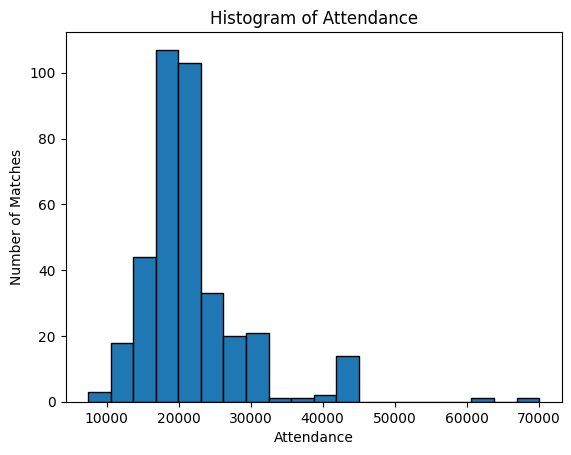

In [99]:
plt.hist(var_att['Attendance'].dropna(), bins=20, edgecolor='black')
plt.xlabel("Attendance")
plt.ylabel("Number of Matches")
plt.title("Histogram of Attendance")
plt.show()

In [100]:
# var_att[var_att['review_type'] == 'Unknown']
# need to fix these at some point 
var_att = var_att.dropna(subset='Attendance')
var_att['Attendance'] = pd.to_numeric(var_att['Attendance'], errors='coerce')

/var/folders/8d/b9k9gx950_58wp12cl76b35m0000gn/T/ipykernel_1553/4164364300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_att['Attendance'] = pd.to_numeric(var_att['Attendance'], errors='coerce')


In [101]:
# let's make attendance bins

var_att["Att_bin"] = pd.qcut(var_att["Attendance"], q=8, labels=[
        "0-12.5%", "12.5-25%", "25-37.5%", "37.5-50%",
        "50-62.5%", "62.5-75%", "75-87.5%", "87.5-100%"
    ])

/var/folders/8d/b9k9gx950_58wp12cl76b35m0000gn/T/ipykernel_1553/466806825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_att["Att_bin"] = pd.qcut(var_att["Attendance"], q=8, labels=[


In [102]:
# good for home column so we can see home field advantage by way of attendance 

var_att['Good_for_Home'] = np.where(
    (var_att['For_Home'] & var_att['Good']) |
    (~var_att['For_Home'] & ~var_att['Good']),
    True,
    False
)

/var/folders/8d/b9k9gx950_58wp12cl76b35m0000gn/T/ipykernel_1553/3928927761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_att['Good_for_Home'] = np.where(


/var/folders/8d/b9k9gx950_58wp12cl76b35m0000gn/T/ipykernel_1553/3649941402.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data = var_att.groupby('Att_bin')['Good_for_Home'].value_counts().unstack(fill_value=0)


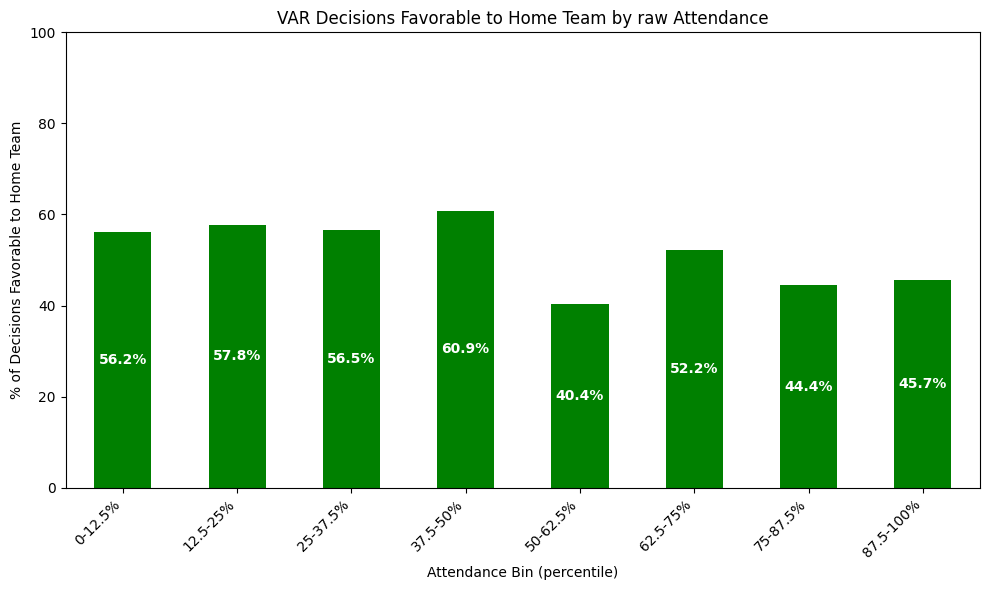

In [147]:
# Group and count
stacked_data = var_att.groupby('Att_bin')['Good_for_Home'].value_counts().unstack(fill_value=0)

# Compute % true
stacked_data['Pct_True'] = stacked_data[True] / (stacked_data[True] + stacked_data[False]) * 100

# Plot just the percentage bars
ax = stacked_data['Pct_True'].plot(kind='bar', color='green', figsize=(10,6))

# Add percentage labels on top of each bar
for i, pct_true in enumerate(stacked_data['Pct_True']):
    ax.text(i, pct_true / 2, f"{pct_true:.1f}%", ha='center', va='center', color='white', fontweight='bold')

plt.xlabel('Attendance Bin (percentile)')
plt.ylabel('% of Decisions Favorable to Home Team')
plt.title('VAR Decisions Favorable to Home Team by raw Attendance')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)  # keep y-axis in % scale
plt.tight_layout()
plt.show()

In [ ]:
# woah
# it looks like you're more likely to get a decision as the home team if there's LESS people there

In [104]:
# let's do attendance as a proportion of the whole stadium now 
var_att['Fullness'] = var_att['Attendance'] / var_att['Capacity']

var_att = var_att.dropna(subset='Fullness')
var_att['Fullness'] = pd.to_numeric(var_att['Fullness'], errors='coerce')

# let's make fullness bins
var_att["Full_bin"] = pd.qcut(var_att["Fullness"], q=8, labels=[
        "0-12.5%", "12.5-25%", "25-37.5%", "37.5-50%",
        "50-62.5%", "62.5-75%", "75-87.5%", "87.5-100%"
    ])

/var/folders/8d/b9k9gx950_58wp12cl76b35m0000gn/T/ipykernel_1553/3418024708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_att['Fullness'] = var_att['Attendance'] / var_att['Capacity']


/var/folders/8d/b9k9gx950_58wp12cl76b35m0000gn/T/ipykernel_1553/924383701.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data2 = var_att.groupby('Full_bin')['Good_for_Home'].value_counts().unstack(fill_value=0)


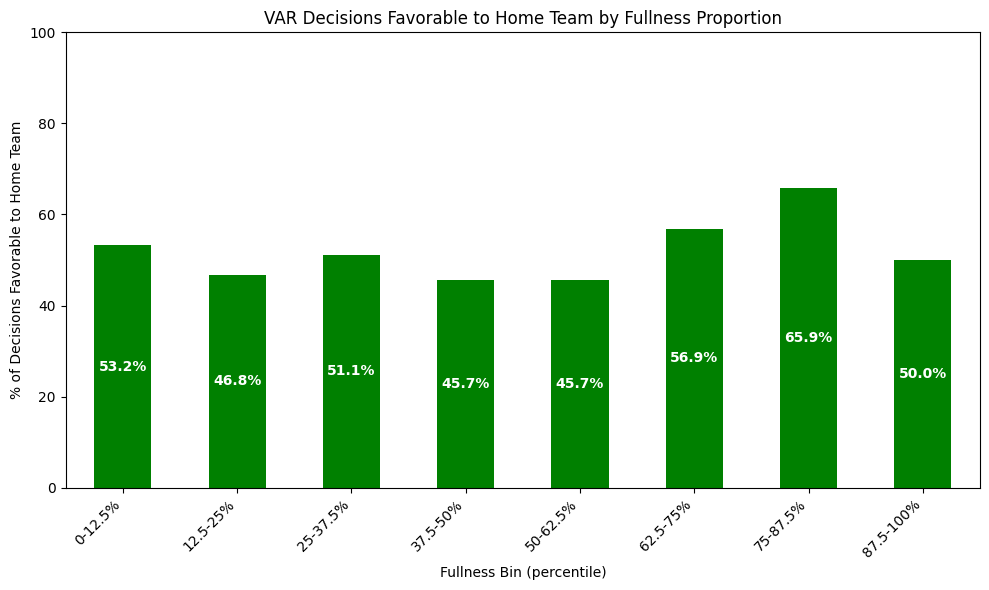

In [150]:
# Group and count
stacked_data2 = var_att.groupby('Full_bin')['Good_for_Home'].value_counts().unstack(fill_value=0)

# Compute % true
stacked_data2['Pct_True'] = stacked_data2[True] / (stacked_data2[True] + stacked_data2[False]) * 100

# Plot just the percentage bars
ax = stacked_data2['Pct_True'].plot(kind='bar', color='green', figsize=(10,6))

# Add percentage labels on top of each bar
for i, pct_true in enumerate(stacked_data2['Pct_True']):
    ax.text(i, pct_true / 2, f"{pct_true:.1f}%", ha='center', va='center', color='white', fontweight='bold')

plt.xlabel('Fullness Bin (percentile)')
plt.ylabel('% of Decisions Favorable to Home Team')
plt.title('VAR Decisions Favorable to Home Team by Fullness Proportion')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)  # keep y-axis in % scale
plt.tight_layout()
plt.show()

In [106]:
var_att.loc[
    (var_att['review_type'] == 'Unknown') & (var_att['var_decision'].str.contains('No card change')),
    'review_type'
] = 'Card'

In [107]:
var_final_prev = pd.read_csv('var_final_prev.csv')

In [108]:
def determine_overturn(row):
    # Check explicit decision overrides first
    decision_text = str(row['var_decision']).lower() if pd.notna(row['var_decision']) else ""
    
    if "decision cancelled" in decision_text or "card upgraded" in decision_text:
        return "Overturned"
    elif "decision confirmed" in decision_text:
        return "Upheld"
    
    # Combine previous commentary safely
    prev_text = ' '.join(str(x) for x in [row['prev1'], row['prev2'], row['prev3']] if pd.notna(x))
    
    # Determine the event type
    event = row['review_type']
    
    # Check if previous commentary mentioned the event
    mentioned = False
    if prev_text:
        if event == 'Card' and 'card' in prev_text.lower():
            mentioned = True
        elif event == 'Penalty' and 'penalty' in prev_text.lower():
            mentioned = True
        elif event == 'Goal' and 'goal' in prev_text.lower():
            mentioned = True

    # Check if the VAR decision was given or not
    given = row['Given']  # assuming boolean

    # Logic for overturn/upheld
    if mentioned and not given:
        return 'Overturned'
    elif mentioned and given:
        return 'Upheld'
    elif not mentioned and not given:
        return 'Upheld'
    else:
        return 'Unclear'

# Apply to the dataframe
var_final_prev['Overturn_Status'] = var_final_prev.apply(determine_overturn, axis=1)

In [109]:
# every red card that was unclear was actually just an upgraded yellow

var_final_prev.loc[
    (var_final_prev['review_type'] == 'Card') & 
    (var_final_prev['Overturn_Status'] == 'Unclear'),
    'Overturn_Status'
] = 'Overturned'

In [110]:
# turning all the missed shots -> goal into overturned (previously unclear)

keywords = ['blocked', 'missed', 'saved']

var_final_prev.loc[
    (var_final_prev['review_type'] == 'Goal') &
    (var_final_prev['Overturn_Status'] == 'Unclear') &
    (var_final_prev[['prev1', 'prev2', 'prev3']].apply(lambda x: any(k.lower() in str(v).lower() for k in keywords for v in x), axis=1)),
    'Overturn_Status'
] = 'Overturned'

In [111]:
# Count total reviews and overturned reviews per referee
ref_summary = var_final_prev.groupby('referee').agg(
    Total_Reviews=('Overturn_Status', 'size'),
    Overturned=('Overturn_Status', lambda x: (x == 'Overturned').sum())
).reset_index()

# Add overturn rate
ref_summary['Overturn_Rate'] = ref_summary['Overturned'] / ref_summary['Total_Reviews']

# Sort by overturn rate (optional)
ref_summary = ref_summary.sort_values(by='Overturn_Rate', ascending=False)

ref_summary[ref_summary['Total_Reviews'] >= 5]

,referee,Total_Reviews,Overturned,Overturn_Rate
30,Mark Allatin,6,6,1.000000
4,Allen Chapman,7,5,0.714286
35,Pierre Luc Lauziere,5,3,0.600000
44,Sergii Boiko,12,7,0.583333
20,Jair Marrufo,7,4,0.571429
18,Ismail Elfath,7,4,0.571429
7,Armando Villarreal,9,5,0.555556
38,Ramy Touchan,11,6,0.545455
48,Tori Penso,8,4,0.500000
3,Alexis Da Silva,12,6,0.500000


In [112]:
var_att['Overturn_Status'] = var_final_prev['Overturn_Status']

In [121]:
# Aggregate per referee
ref_summary_att = var_att.groupby('referee').agg(
    Total_Reviews=('Overturn_Status', 'size'),
    Overturned_Count=('Overturn_Status', lambda x: (x == 'Overturned').sum()),
    Good_Count=('Good', 'sum'),
    Good_for_Home_Count=('Good_for_Home', 'sum')
).reset_index()

# Add rates
ref_summary_att['Overturn_Rate'] = (ref_summary_att['Overturned_Count'] / ref_summary_att['Total_Reviews'] * 100).round(1)
ref_summary_att['Good_Rate'] = (ref_summary_att['Good_Count'] / ref_summary_att['Total_Reviews'] * 100).round(1)
ref_summary_att['Good_for_Home_Rate'] = (ref_summary_att['Good_for_Home_Count'] / ref_summary_att['Total_Reviews'] * 100).round(1)

# Optional: sort by overturn rate
ref_summary_att = ref_summary_att.sort_values(by='Overturn_Rate', ascending=False)

# Optional: filter for refs with at least 5 reviews
ref_summary_att = ref_summary_att[ref_summary_att['Total_Reviews'] >= 5]

ref_summary_att

,referee,Total_Reviews,Overturned_Count,Good_Count,Good_for_Home_Count,Overturn_Rate,Good_Rate,Good_for_Home_Rate
30,Mark Allatin,6,6,2,6,100.0,33.3,100.0
4,Allen Chapman,7,5,1,1,71.4,14.3,14.3
35,Pierre Luc Lauziere,5,3,1,2,60.0,20.0,40.0
44,Sergii Boiko,12,7,2,5,58.3,16.7,41.7
20,Jair Marrufo,7,4,1,0,57.1,14.3,0.0
18,Ismail Elfath,7,4,2,5,57.1,28.6,71.4
7,Armando Villarreal,9,5,4,7,55.6,44.4,77.8
3,Alexis Da Silva,11,6,6,5,54.5,54.5,45.5
38,Ramy Touchan,11,6,3,3,54.5,27.3,27.3
48,Tori Penso,8,4,4,6,50.0,50.0,75.0


In [122]:
ref_summary_att.to_csv('/Users/arthurlennard//Desktop/MLS Data Science/Ref_Summary.csv')

In [145]:
# var[var['review_type'] == 'Card']
# 328, 362, 319, 347, 372, 354, 317, 369, 323, 336

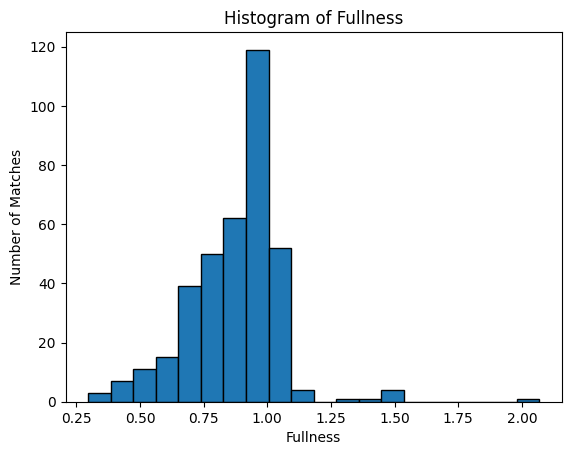

In [156]:
plt.hist(var_att['Fullness'].dropna(), bins=20, edgecolor='black')
plt.xlabel("Fullness")
plt.ylabel("Number of Matches")
plt.title("Histogram of Fullness")
plt.show()

In [155]:
var_att[var_att['Stadium'] == 'Gillette Stadium']

,Unnamed: 0,home_team,away_team,minute,var_text,home_score_at_time,away_score_at_time,referee,var_decision,Set_Piece,...,review_type,Attendance,Stadium,Team,Capacity,Att_bin,Good_for_Home,Fullness,Full_bin,Overturn_Status
16,16,NE Revolution,NYCFC,62,VAR Decision: No Goal New England Revolution 0...,1.0,1.0,Ismail Elfath,VAR Decision: No Goal New,True,...,Goal,18521,Gillette Stadium,New England Revolution,20000.0,25-37.5%,True,0.92605,50-62.5%,Overturned
23,23,NE Revolution,CF Montréal,45,VAR Decision: Penalty New England Revolution.,2.0,0.0,Tori Penso,VAR Decision: Penalty New England,False,...,Penalty,18021,Gillette Stadium,New England Revolution,20000.0,12.5-25%,True,0.90105,37.5-50%,Upheld
29,29,NE Revolution,Sporting KC,59,VAR Decision: Card upgraded Andreu Fontàs (Spo...,2.0,1.0,Nima Saghafi,VAR Decision: Card upgraded Andreu,True,...,Card,19281,Gillette Stadium,New England Revolution,20000.0,37.5-50%,True,0.96405,50-62.5%,Overturned
34,34,NE Revolution,FC Cincinnati,66,VAR Decision: No Penalty FC Cincinnati.,1.0,1.0,Alex Chilowicz,VAR Decision: No Penalty FC,False,...,Penalty,30080,Gillette Stadium,New England Revolution,20000.0,87.5-100%,True,1.50400,87.5-100%,Upheld
165,165,NE Revolution,Philadelphia Union,45,VAR Decision: Card upgraded Mark-Anthony Kaye ...,0.0,0.0,Drew Fischer,VAR Decision: Card upgraded Mark,False,...,Card,41355,Gillette Stadium,New England Revolution,20000.0,87.5-100%,False,2.06775,87.5-100%,Overturned
280,280,NE Revolution,St. Louis,82,VAR Decision: No Penalty New England Revolution.,2.0,2.0,Timothy Ford,VAR Decision: No Penalty New,True,...,Penalty,30512,Gillette Stadium,New England Revolution,20000.0,87.5-100%,False,1.52560,87.5-100%,Upheld
314,314,NE Revolution,Columbus Crew,90,VAR Decision: No Penalty New England Revolution.,0.0,1.0,Filip Dujic,VAR Decision: No Penalty New,True,...,Penalty,22274,Gillette Stadium,New England Revolution,20000.0,62.5-75%,False,1.11370,87.5-100%,Upheld
329,329,NE Revolution,NY Red Bulls,90,VAR Decision: Penalty New England Revolution.,2.0,1.0,Sergii Demianchuk,VAR Decision: Penalty New England,False,...,Penalty,20439,Gillette Stadium,New England Revolution,20000.0,50-62.5%,True,1.02195,87.5-100%,Upheld
330,330,NE Revolution,NY Red Bulls,67,VAR Decision: No Penalty New England Revolution.,2.0,1.0,Sergii Demianchuk,VAR Decision: No Penalty New,True,...,Penalty,20439,Gillette Stadium,New England Revolution,20000.0,50-62.5%,False,1.02195,87.5-100%,Upheld
